In [26]:
import logging
logging.basicConfig(level=logging.WARN)

from copy import copy

import gym
import gym_multiplexer

from lcs import Perception
from lcs.agents import EnvironmentAdapter
from lcs.metrics import population_metrics
from lcs.agents.acs2 import ACS2
from lcs.strategies.action_selection import BestAction, EpsilonGreedy, KnowledgeArray, ActionDelay

from utils.mpx import avg_experiments
from utils.plotting import COLORS

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib.ticker as mtick

rc('pdf', **{'fonttype': 42})
rc('ps', **{'fonttype': 42})
rc('font', **{'family':'sans-serif', 'sans-serif': ['DejaVu Sans'],'size': 14})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # comment if you don't have high-res display

TypeError: rc() takes 1 positional argument but 2 were given

## Experiment settings

In [2]:
BINS = 6

experiments = 10

trials = 2*10000 # explore-exploit-explore-...

## Environment

In [3]:
rmpx_bits = 6  # [3, 6]
ENV_NAME = f"real-multiplexer-{rmpx_bits}bit-v0"

env = gym.make(ENV_NAME)

In [4]:
# visualization
env.reset()
env.render()

[0.40365623534850537, 0.8763343545283117, 0.9628632733339042, 0.4514367415470373, 0.4117200427642149, 0.8854644318464701, 0.0]


### Phenotype adapter (discretizer)

In [5]:
_range, _low = (env.observation_space.high - env.observation_space.low, env.observation_space.low)

class RealMultiplxerAdapter(EnvironmentAdapter):
    @classmethod
    def to_genotype(cls, obs):
        r = (obs + np.abs(_low)) / _range
        b = (r * BINS).astype(int)
        return b.astype(str).tolist()



['0', '4', '1', '0', '1', '4', '0']

In [21]:
# verify
adapter = RealMultiplxerAdapter()

state = env.reset()
discretized = adapter.to_genotype(state)

state, discretized

([0.8646598496102387,
  0.29040916462940825,
  0.5635758508953909,
  0.8979192434550662,
  0.33615012165089697,
  0.49621226229194604,
  0.0],
 ['5', '1', '3', '5', '2', '2', '0'])

In [6]:
def rmpx_metrics(pop, env):
    metrics = {
        'reliable': len([cl for cl in pop if cl.is_reliable()])
    }
    metrics.update(population_metrics(pop, env))
    return metrics

In [7]:
base_params = {
    "classifier_length": rmpx_bits+1,
    "number_of_possible_actions": 2,
    "epsilon": 0.8,
    "beta": 0.2,
    "gamma": 0.95,
    "initial_q": 0.5,
    "theta_exp": 50,
    "theta_ga": 50,
    "do_ga": True,
    "chi": 0.0,  # do not cross-over
    "mu": 0.03,
    "u_max": 4,
    "metrics_trial_frequency": 1,
    "environment_adapter": RealMultiplxerAdapter,
    "user_metrics_collector_fcn": rmpx_metrics
}

## Experimentation
Perform `explore-exploit` type of interaction

### Epsilon Greedy (baseline)

In [8]:
%%time

epsilon_greedy_params = copy(base_params)
epsilon_greedy_params['action_selector'] = EpsilonGreedy

epsilon_greedy_df = avg_experiments(experiments, env, trials, **epsilon_greedy_params)

{'classifier_length': 7, 'number_of_possible_actions': 2, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'chi': 0.0, 'mu': 0.03, 'u_max': 4, 'metrics_trial_frequency': 1, 'environment_adapter': <class '__main__.RealMultiplxerAdapter'>, 'user_metrics_collector_fcn': <function rmpx_metrics at 0x11d7d40e0>, 'action_selector': <class 'lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy'>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
CPU times: user 1h 29min 11s, sys: 12.8 s, total: 1h 29min 23s
Wall time: 1h 32min 46s


### Action Delay Bias

In [9]:
%%time

action_delay_params = copy(base_params)
action_delay_params['biased_exploration_prob'] = 0.5
action_delay_params['action_selector'] = ActionDelay

action_delay_df = avg_experiments(experiments, env, trials, **action_delay_params)

{'classifier_length': 7, 'number_of_possible_actions': 2, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'chi': 0.0, 'mu': 0.03, 'u_max': 4, 'metrics_trial_frequency': 1, 'environment_adapter': <class '__main__.RealMultiplxerAdapter'>, 'user_metrics_collector_fcn': <function rmpx_metrics at 0x11d7d40e0>, 'biased_exploration_prob': 0.5, 'action_selector': <class 'lcs.strategies.action_selection.ActionDelay.ActionDelay'>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
CPU times: user 1h 25min 8s, sys: 11.1 s, total: 1h 25min 19s
Wall time: 1h 26min 42s


### Knowledge Array Bias

In [10]:
%%time

knowledge_array_params = copy(base_params)
knowledge_array_params['biased_exploration_prob'] = 0.5
knowledge_array_params['action_selector'] = KnowledgeArray

knowledge_array_df = avg_experiments(experiments, env, trials, **knowledge_array_params)

{'classifier_length': 7, 'number_of_possible_actions': 2, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'chi': 0.0, 'mu': 0.03, 'u_max': 4, 'metrics_trial_frequency': 1, 'environment_adapter': <class '__main__.RealMultiplxerAdapter'>, 'user_metrics_collector_fcn': <function rmpx_metrics at 0x11d7d40e0>, 'biased_exploration_prob': 0.5, 'action_selector': <class 'lcs.strategies.action_selection.KnowledgeArray.KnowledgeArray'>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
CPU times: user 1h 29min 21s, sys: 10.6 s, total: 1h 29min 32s
Wall time: 1h 29min 58s


### Optimistic Initial Quality

In [11]:
%%time

op_initial_params = copy(base_params)
op_initial_params['action_selector'] = EpsilonGreedy
op_initial_params['initial_q'] = 0.8

op_initial_df = avg_experiments(experiments, env, trials, **op_initial_params)

{'classifier_length': 7, 'number_of_possible_actions': 2, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.8, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'chi': 0.0, 'mu': 0.03, 'u_max': 4, 'metrics_trial_frequency': 1, 'environment_adapter': <class '__main__.RealMultiplxerAdapter'>, 'user_metrics_collector_fcn': <function rmpx_metrics at 0x11d7d40e0>, 'action_selector': <class 'lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy'>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
CPU times: user 1h 24min 7s, sys: 7.44 s, total: 1h 24min 14s
Wall time: 1h 24min 26s


## Visualization

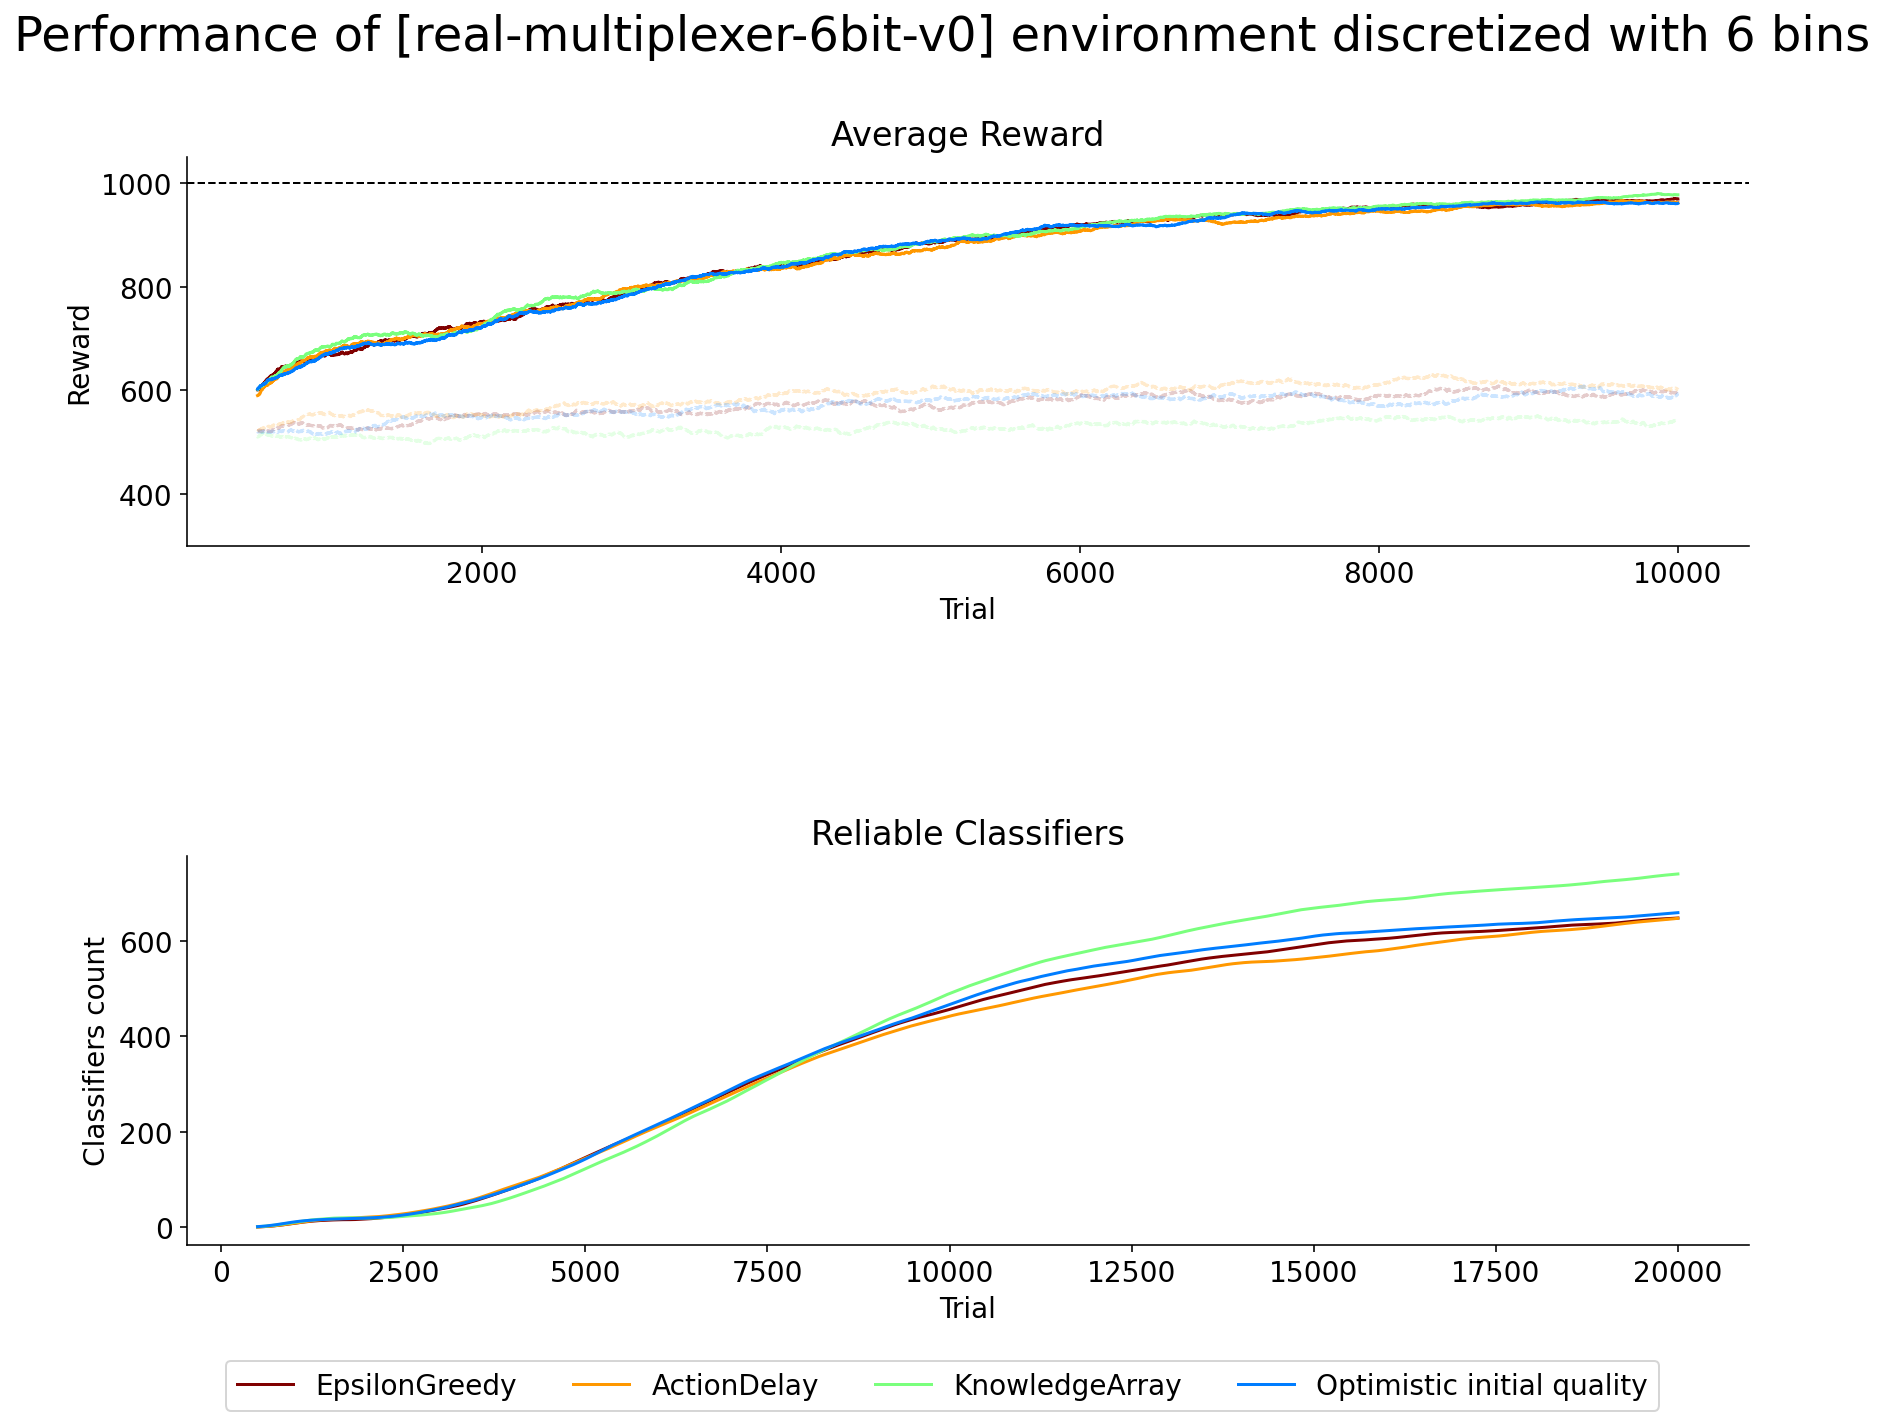

In [25]:
def plot_by_phase(df, window, label, color, ax):
    explore_df = df[df['phase'] == 'explore']
    exploit_df = df[df['phase'] == 'exploit']
    
    explore_df.reset_index(inplace=True)
    exploit_df.reset_index(inplace=True)
    
    explore_df['reward'].rolling(window=window).mean().plot(label=label, color=color, ls='--', alpha=0.2, ax=ax)
    exploit_df['reward'].rolling(window=window).mean().plot(label=label, color=color, ax=ax)


fig = plt.figure(figsize=(14, 10))

# Plots layout
gs = fig.add_gridspec(2,1, hspace=.8)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Global title
fig.suptitle(f'Performance of [{env.unwrapped.spec.id}] environment discretized with {BINS} bins', fontsize=24)

# Each axis
ma_window = 500  # moving averge window

# Average reward
plot_by_phase(epsilon_greedy_df, ma_window, epsilon_greedy_params['action_selector'].__name__, COLORS['eg'], ax1)
plot_by_phase(action_delay_df, ma_window, action_delay_params['action_selector'].__name__, COLORS['ad'], ax1)
plot_by_phase(knowledge_array_df, ma_window, knowledge_array_params['action_selector'].__name__, COLORS['ka'], ax1)
plot_by_phase(op_initial_df, ma_window, 'Optimistic initial quality', COLORS['oiq'], ax1)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Average Reward');
ax1.set_xlabel('Trial')
ax1.set_ylabel('Reward')
ax1.set_ylim(300, 1050)
ax1.axhline(y=1000, color='black', linewidth=1, linestyle="--")

# Population
epsilon_greedy_df['reliable'].rolling(window=ma_window).mean().plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax2)
action_delay_df['reliable'].rolling(window=ma_window).mean().plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax2)
knowledge_array_df['reliable'].rolling(window=ma_window).mean().plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax2)
op_initial_df['reliable'].rolling(window=ma_window).mean().plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('Trial')
ax2.set_ylabel('Classifiers count')
ax2.set_title('Reliable Classifiers')
ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

# Create legend
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4);

# Save plot to file
fig.savefig('rmpx-performance.pdf')